# Evaluation on Synthetic Data 

## Imports

In [1]:
# Cell for personal sys path fixes ...
import sys
sys.path=['', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/bin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/krell/Library/Python/2.7/lib/python/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/aubio-0.4.5a1-py2.7-macosx-10.12-x86_64.egg', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/extensions', '/Users/krell/.ipython']
sys.path.append("/Users/krell/Documents/pyspace")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

from sklearn.metrics import r2_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.svm import SVR

from scipy.stats import norm, uniform
from scipy.stats import gaussian_kde
from statsmodels.api import nonparametric
KDEMultivariate = nonparametric.KDEMultivariate
default_KDE = nonparametric.EstimatorSettings(efficient=True)

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__
import numpy; print "  numpy:", numpy.__version__
import matplotlib; print "  matplotlib:", matplotlib.__version__

Package Versions:
  scikit-learn: 0.18.1
  scipy: 0.19.0
  statsmodels: 0.8.0
  numpy: 1.12.1
  matplotlib: 2.0.0


## Core Functions

In [3]:
def weight_by_histogram(data):
    """Extract density weighting from histogram
    
    The number of bins is chosen according to D. Freedman, P. Diaconis,
    'On the histogram as a density estimator:L 2 theory', 1981 
    """
    hist, bin_edges = np.histogram(data,bins='fd',normed=True)
    density = np.zeros(data.shape[0])
    for i, x in enumerate(data):
        for j in range(len(hist)):
            if (x >= bin_edges[j] and x <= bin_edges[j+1]):
                density[i] = hist[j]
                break
    return density

def calculate_metrics(act, pred, feat=None, feat_weighting=False, 
                              metrics=None, label=""):
    """Calculate normal regression metrics as well as corrected ones
    
    :returns: metric dictionary with respective keys for the metrics,
        and the weight names that were used for correcting imbalance.
    
    **Parameters**
    
        :act: actual values (list of real values or 1-D array)
        :pred: predicted values (list of real values or 1-D array)
        :feat: original samples as feature vectors
        :feat_weighting: True if weighting should be done by the 
            distribution calculated on *feat* samples instead of *act* 
            samples
        :metrics: dictionary that gets filled with the added metrics.
        :label: Prefix to be added to the metric names, like train/test to
            distinguish between metrics calculated on training or testing 
            data or different components for multivariate evaluation.
    """
    # init
    if metrics is None:
        metrics = defaultdict(float)
    weights_list = [None]
    weights_name = [""]
    if feat_weighting:
        if feat != None:
            weighting_by = feat
        else:
            print "Warning: no features given as input, " + \
                  "weighting by targets.."
            weighting_by = act
    else:
        weighting_by = act

    # Get weights from statspackages
    # other possible methods: "cv_ml" and "normal_reference"
    for method in ["cv_ls"]:
        t = time.time()
        kde = KDEMultivariate(
                data=[weighting_by], var_type='c', bw=method,
                defaults=default_KDE)
        tf = time.time()
        # uses same data for training and generating weights automatically
        inverse_weights = kde.pdf()
        weights_list.append(1.0 / inverse_weights)
        weights_name.append("_" + method)
        print method , "done:", tf-t, " time used" 
    # "silverman" could be also used
    for method in ["scott"]:
        kde = gaussian_kde(weighting_by, method)
        # use same data for training and generating weights
        inverse_weights = kde(weighting_by)
        weights_list.append(1.0 / inverse_weights)
        weights_name.append("_" + method)

    # Only the median metric does not allow for weighting
    metrics[label+"Sklearn_median_absolute_error"] = \
        median_absolute_error(act, pred)
    # Calculate all the metrics for all possible weight corrections
    # (including no weight correction)
    for i in range(len(weights_list)):
        weights = weights_list[i]
        w = weights_name[i]
        # sklearn metrics
        metrics[label+"Sklearn_R2_score"+w] = r2_score(act, pred, weights)
        metrics[label+"Sklearn_explained_variance_score"+w] = \
            explained_variance_score(act, pred, weights)
        metrics[label+"Sklearn_mean_absolute_error"+w] = \
            mean_absolute_error(act, pred, weights)
        metrics[label+"Sklearn_mean_squared_error"+w] = \
            mean_squared_error(act, pred, weights)
        ######################################################## 
        # other standard metrics
        metrics[label+"Mean-squared_error"+w] = \
            np.average((pred-act)**2, weights=weights)
        metrics[label+"Root_mean-squared_error"+w] = \
            np.sqrt(metrics[label+"Mean-squared_error"+w])
        metrics[label+"Mean_absolute_error"+w] = \
            np.average(np.abs(pred-act), weights=weights)
        metrics[label+"Relative_squared_error"+w] = \
            metrics[label+"Mean-squared_error"+w] / np.average((act - 
                        np.average(act, weights=weights))**2, 
                                                       weights=weights)
        metrics[label+"Root_relative_squared_error"+w] = \
            np.sqrt(metrics[label+"Relative_squared_error"+w])
        metrics[label+"Relative_absolute_error"+w] = \
            metrics[label+"Mean_absolute_error"+w] / np.average(np.abs((
                act - np.average(act, weights=weights))), weights=weights)
        cov = np.cov(act, pred, aweights=weights)
        metrics[label+"Correlation_coefficient"+w] = \
            cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    return metrics, weights_name

In [4]:
def plot_metrics(metrics, weights_names):
    """Plot a 2x3 grid of images for different metrics comparing weigtings
    
    It takes the metrics dictionary from :func:`calculate:metrics` as input
    and the names of the calculated weights.
    Each weighting provides a point in the curve for the weighting.
    """
    # extract metrics
    R2,EVS,MSE,MAE,COR,RAE = [],[],[],[],[],[]
    for w in weights_names:
        R2.append(metrics['Sklearn_R2_score'+w])
        EVS.append(metrics['Sklearn_explained_variance_score'+w])
        MAE.append(metrics['Sklearn_mean_absolute_error'+w])
        MSE.append(metrics['Sklearn_mean_squared_error'+w])
        COR.append(metrics['Correlation_coefficient'+w])
        RAE.append(metrics['Relative_absolute_error'+w])
    print weights_names
    # print metrics
    x_labels = weights_names
    fig, axx = plt.subplots(2, 3, figsize=(16,8))
    axx[0,0].plot(R2,'-v')
    axx[0,0].set_title('COD')
    axx[0,1].plot(EVS,'-v')
    axx[0,1].set_title('EVS')
    axx[0,2].plot(COR,'-v')
    axx[0,2].set_title('PCC')
    axx[1,0].plot(MSE,'-v')
    axx[1,0].set_title('MSE')
    axx[1,1].plot(MAE,'-v')
    axx[1,1].set_title('MAE')
    axx[1,2].plot(RAE,'-v')
    axx[1,2].set_title('RAE')
    for i in range(2):
        for j in range(3):
            axx[i,j].set_xticks(range(len(R2)))
            axx[i,j].set_xticklabels(x_labels) 

In [5]:
def extract_metrics_multiple(y, y_pred):
    """Calculates lists for the different metrics for each dimension in y
    
    y denotes the actual values and y_pred the predicted samples.

    The six different metric lists are returned as a tuple
    together with the weight names.
    """
    R2,EVS,MSE,MAE,COR,RAE = [],[],[],[],[],[]
    for i in range(0,y.shape[0]):
        metrics, weights_names = calculate_metrics(y[i], y_pred[i])
        R2_i,EVS_i,MSE_i,MAE_i,COR_i,RAE_i = [],[],[],[],[],[]
        for w in weights_names:
            R2_i.append(metrics['Sklearn_R2_score'+w])
            EVS_i.append(metrics['Sklearn_explained_variance_score'+w])
            MAE_i.append(metrics['Sklearn_mean_absolute_error'+w])
            MSE_i.append(metrics['Sklearn_mean_squared_error'+w])
            COR_i.append(metrics['Correlation_coefficient'+w])
            RAE_i.append(metrics['Relative_absolute_error'+w])
        R2.append(R2_i)
        EVS.append(EVS_i)
        MAE.append(MAE_i)
        MSE.append(MSE_i)
        COR.append(COR_i)
        RAE.append(RAE_i)
    return ([R2, EVS, MAE, MSE, COR, RAE],weights_names)

def extract_xmetrics_multiple(y, y_pred, x):
    """Like :func:`extract_metrics_multiple` but with sample based weighting
    
    y denotes the actual values, y_pred the predicted samples, and 
    x the respective original samples which were used to calculate the
    distribution.

    The six different metric lists are returned as a tuple
    together with the weight names.
    """
    R2,EVS,MSE,MAE,COR,RSE = [],[],[],[],[],[]
    for i in range(0,y.shape[0]):
        metrics, weights_names = calculate_metrics(
            y[i], y_pred[i], feat=x[i], feat_weighting=True)
        R2_i,EVS_i,MSE_i,MAE_i,COR_i,RSE_i = [],[],[],[],[],[]
        for w in weights_names:
            R2_i.append(metrics['Sklearn_R2_score'+w])
            EVS_i.append(metrics['Sklearn_explained_variance_score'+w])
            MAE_i.append(metrics['Sklearn_mean_absolute_error'+w])
            MSE_i.append(metrics['Sklearn_mean_squared_error'+w])
            COR_i.append(metrics['Correlation_coefficient'+w])
            RSE_i.append(metrics['Relative_absolute_error'+w])
        R2.append(R2_i)
        EVS.append(EVS_i)
        MAE.append(MAE_i)
        MSE.append(MSE_i)
        COR.append(COR_i)
        RSE.append(RSE_i)
    return ([R2, EVS, MAE, MSE, COR, RSE],weights_names)


## Generate and Plot Synthetic Data with Moving Mean

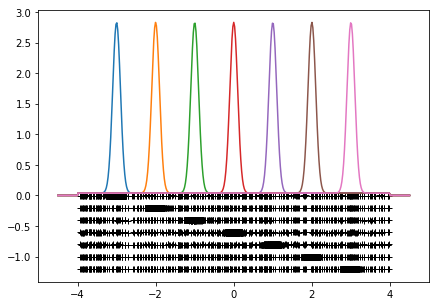

In [6]:
# init
np.random.seed(1)
n_samples = 1000
sd = 0.1
means = [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
X_plot = np.linspace(-4.5, 4.5, 401)[:, np.newaxis]
x = np.zeros((len(means),n_samples))
true_dens = np.zeros((len(means),X_plot.size))
plt.figure(figsize=(7,5))

# generate and plot distribution for each mean
for i, mean in enumerate(means):
    np.random.seed(1)
    # mix normal (70%) and uniform (30%) distribution
    x[i] =  np.concatenate((
        np.random.normal(mean, sd, int(0.7 * n_samples)), 
        np.random.uniform(-4,4, int(0.3 * n_samples))))
    np.random.seed(1)
    true_dens[i] = (0.3 * uniform.pdf(X_plot,loc=-4,scale=8).flatten() + \
                    0.7 * norm(mean, sd).pdf(X_plot[:, 0]))
    # plot true density curve
    plt.plot(X_plot, true_dens[i], label='density of x')
    # scatter plot
    plt.plot(x[i], -i * 0.2 - 0.01 * 
             np.random.random(x[i].shape[0]), '+k', label='x samples')
    plt.xlim(-5, 5)

## Generate regression metric data with 3 functions

In [11]:
# Apply function 1 to data from different distributions
def func1(x):
    return 0.2 * x * x

np.random.seed(1)
y1 = func1(x) + 0.1 * np.random.rand(n_samples)
# Train scikit SVR on first dataset with mean -3 for the normal distribution
svr = SVR(C=0.1, gamma=10, epsilon=0.1).fit(x[0,:][:,None], y1[0])
# Generate prediction values on the training data
y1_pred = np.zeros((len(means), n_samples))
for i, mean in enumerate(means):
    y1_pred[i] = svr.predict(x[i,:][:,None])
# Calculate metrics
metrics1, weight_names = extract_metrics_multiple(y1, y1_pred)


# Same as before but with function 2 and C=0.5
def func2(x):
    return x * np.abs(x)

np.random.seed(1)
y2 = func2(x) + 0.1 * np.random.rand(n_samples)
svr = SVR(C=0.5,gamma=10,epsilon=0.1).fit(x[0,:][:,None], y2[0])
y2_pred = np.zeros((len(means), n_samples))
for i, mean in enumerate(means):
    y2_pred[i] = svr.predict(x[i,:][:,None])
metrics2, weight_names = extract_metrics_multiple(y2, y2_pred)


# Same as for function 1 but with function 3
def func3(x):
    return 10 * np.cos(x) * np.cos(x)

np.random.seed(1)
y3 = func3(x) + 0.1 * np.random.rand(n_samples)
svr = SVR(C=0.1,gamma=10,epsilon=0.1).fit(x[0,:][:,None],y3[0])
y3_pred = np.zeros((len(means),n_samples))

for i, mean in enumerate(means):
    y3_pred[i] = svr.predict(x[i,:][:,None])
metrics3, weight_names = extract_metrics_multiple(y3, y3_pred)

cv_ls done: 0.686686992645  time used
cv_ls done: 0.729719161987  time used
cv_ls done: 0.689501047134  time used
cv_ls done: 3.14302921295  time used
cv_ls done: 0.8312458992  time used
cv_ls done: 0.778170108795  time used
cv_ls done: 0.886668205261  time used
cv_ls done: 5.89814901352  time used
cv_ls done: 5.43715906143  time used
cv_ls done: 5.53796577454  time used
cv_ls done: 5.32212305069  time used
cv_ls done: 5.70283985138  time used
cv_ls done: 6.1340739727  time used
cv_ls done: 5.56125688553  time used
cv_ls done: 0.928562879562  time used
cv_ls done: 0.814470052719  time used
cv_ls done: 0.949155807495  time used
cv_ls done: 0.941684007645  time used
cv_ls done: 0.939609050751  time used
cv_ls done: 0.916711091995  time used
cv_ls done: 0.997735977173  time used


## Combine Results from All 3 Functions Into One Plot

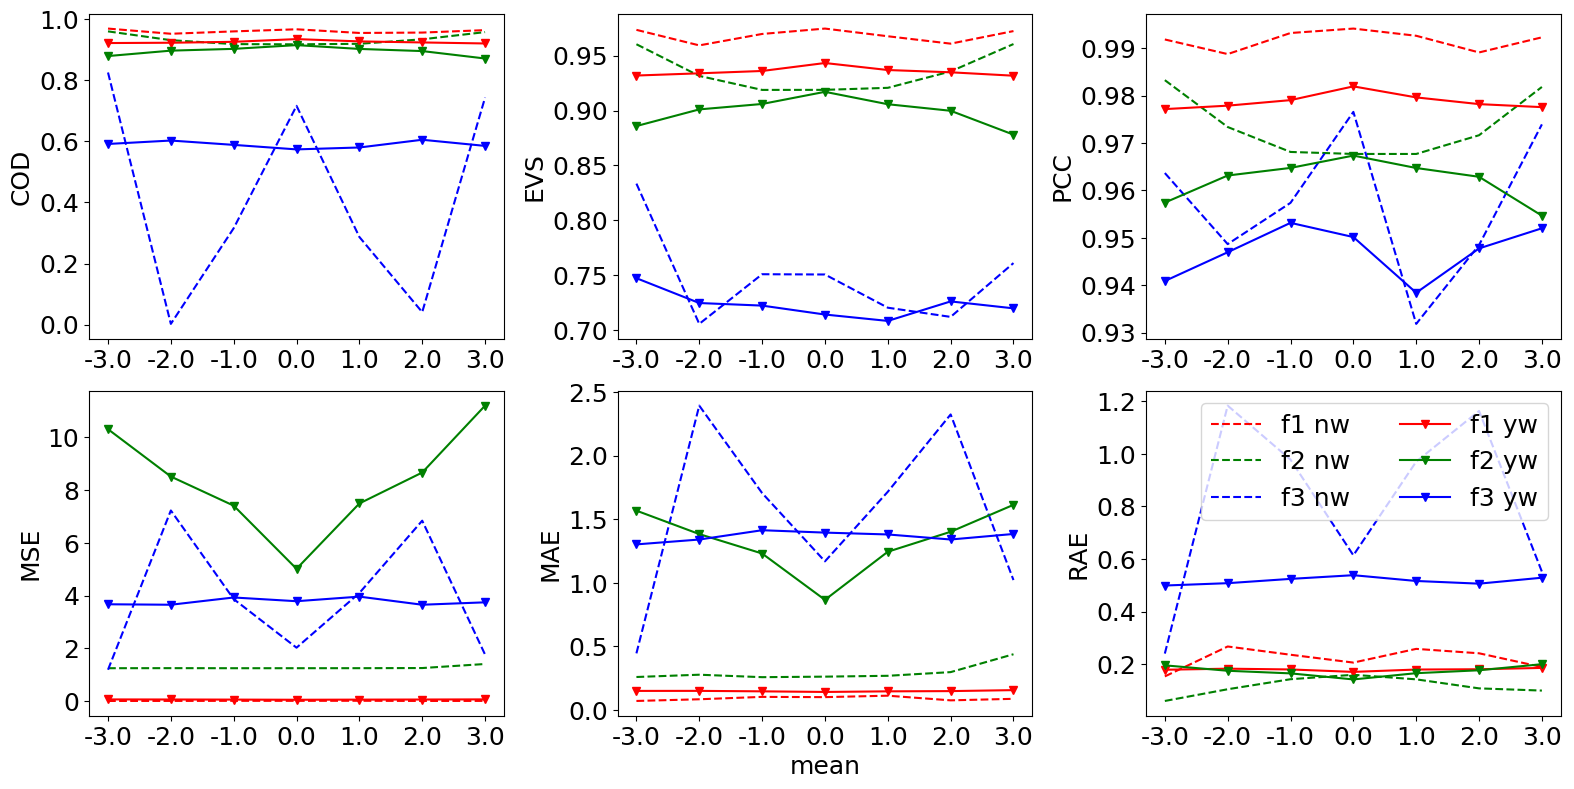

In [12]:
# Reset plot environment and define colors for plotting
# Provide same coloring for same dataset
plt.rcParams.update(plt.rcParamsDefault)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b']*2)))
label_size = 18
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 


labels = means
fig, axx = plt.subplots(2, 3, figsize=(16,8))

for R2, EVS, MAE, MSE, COR, RSE in [metrics1, metrics2, metrics3]:
    axx[0,0].plot(np.array(R2)[:,0],'--') 
    axx[0,0].set_ylabel('COD', fontsize=label_size)
    axx[0,1].plot(np.array(EVS)[:,0],'--')
    axx[0,1].set_ylabel('EVS', fontsize=label_size)
    axx[0,2].plot(np.array(COR)[:,0],'--')
    axx[0,2].set_ylabel('PCC', fontsize=label_size)
    axx[1,0].plot(np.array(MSE)[:,0],'--')
    axx[1,0].set_ylabel('MSE', fontsize=label_size)
    axx[1,1].plot(np.array(MAE)[:,0],'--')
    axx[1,1].set_ylabel('MAE', fontsize=label_size)
    axx[1,1].set_xlabel("mean", fontsize=label_size)
    axx[1,2].plot(np.array(RSE)[:,0],'--')
    axx[1,2].set_ylabel('RAE', fontsize=label_size)

for R2, EVS, MAE, MSE, COR, RSE in [metrics1, metrics2, metrics3]:
    axx[0,0].plot(np.array(R2)[:,1],'-v') 
    axx[0,1].plot(np.array(EVS)[:,1],'-v')
    axx[0,2].plot(np.array(COR)[:,1],'-v')
    axx[1,0].plot(np.array(MSE)[:,1],'-v')
    axx[1,1].plot(np.array(MAE)[:,1],'-v')
    axx[1,2].plot(np.array(RSE)[:,1],'-v')
plt.setp(axx, xticks=range(len(R2)), xticklabels = labels)
plt.legend(['f1 nw', 'f2 nw', 'f3 nw', 'f1 yw', 'f2 yw', 'f3 yw'], 
           ncol=2, fontsize=label_size)
plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault)

## Same Metric Evaluation but with x-weighting

In [9]:
xmetrics1, weight_names = extract_xmetrics_multiple(y1, y1_pred,x)
xmetrics2, weight_names = extract_xmetrics_multiple(y2, y2_pred,x)
xmetrics3, weight_names = extract_xmetrics_multiple(y3, y3_pred,x)

cv_ls done: 0.957019090652  time used
cv_ls done: 1.11377692223  time used
cv_ls done: 1.04096412659  time used
cv_ls done: 0.987631082535  time used
cv_ls done: 0.931058883667  time used
cv_ls done: 0.822278022766  time used
cv_ls done: 0.907917022705  time used
cv_ls done: 0.847446918488  time used
cv_ls done: 0.867887973785  time used
cv_ls done: 0.769399881363  time used
cv_ls done: 0.793721914291  time used
cv_ls done: 0.747489929199  time used
cv_ls done: 0.890693902969  time used
cv_ls done: 0.823339939117  time used
cv_ls done: 0.833117008209  time used
cv_ls done: 0.849904060364  time used
cv_ls done: 0.869445085526  time used
cv_ls done: 0.84462594986  time used
cv_ls done: 0.867161989212  time used
cv_ls done: 0.877578020096  time used
cv_ls done: 0.853539943695  time used


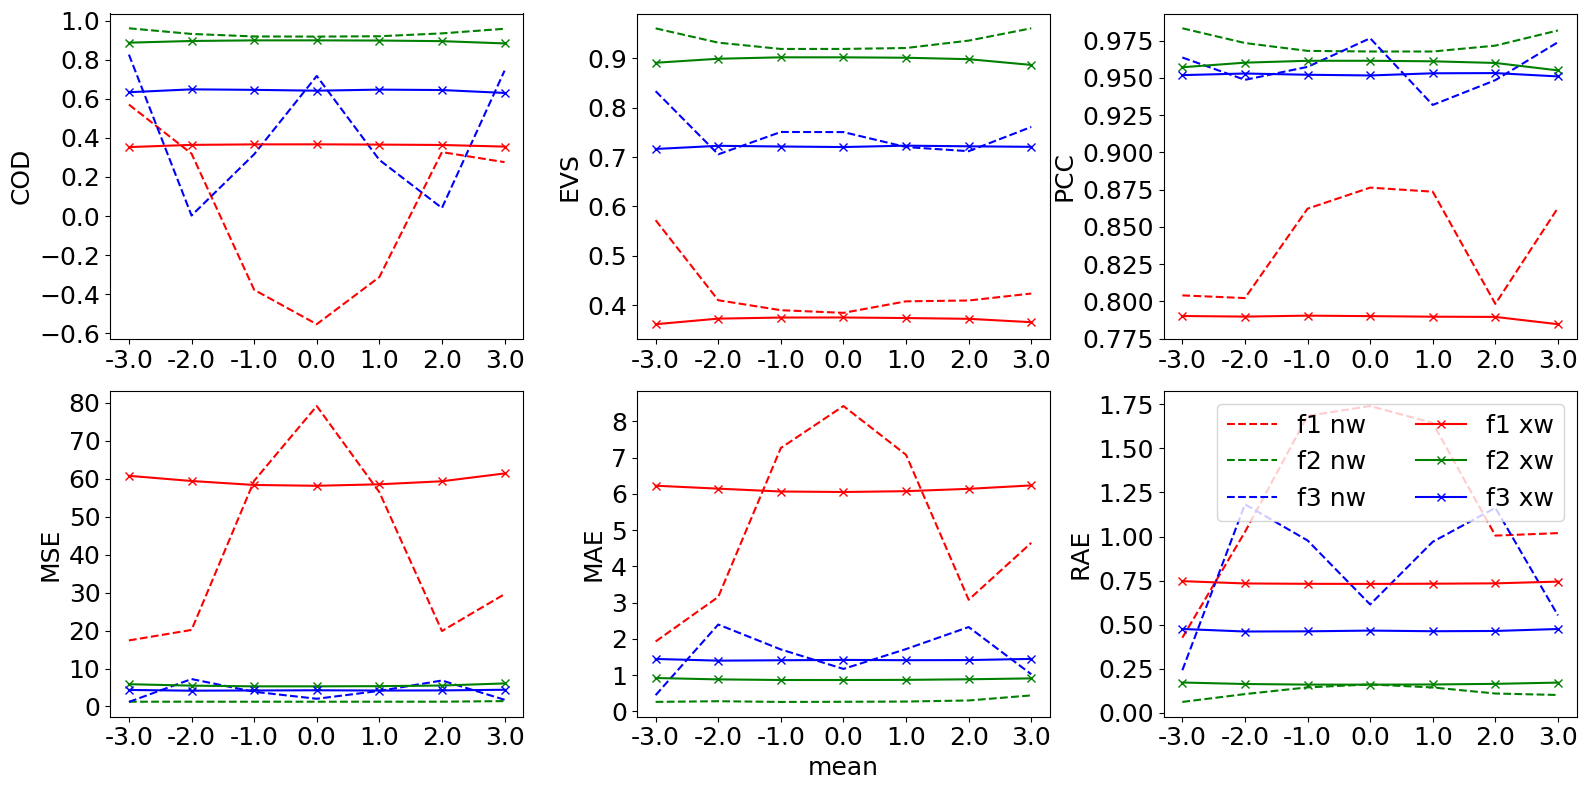

In [10]:
# Reset plot environment and define colors for plotting
# Provide same coloring for same dataset
plt.rcParams.update(plt.rcParamsDefault)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b']*2)))
label_size = 18
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 


labels = means
fig, axx = plt.subplots(2, 3, figsize=(16,8))

for R2, EVS, MAE, MSE, COR, RSE in [xmetrics1, xmetrics2, xmetrics3]:
    axx[0,0].plot(np.array(R2)[:,0],'--') 
    axx[0,0].set_ylabel('COD', fontsize=label_size)
    axx[0,1].plot(np.array(EVS)[:,0],'--')
    axx[0,1].set_ylabel('EVS', fontsize=label_size)
    axx[0,2].plot(np.array(COR)[:,0],'--')
    axx[0,2].set_ylabel('PCC', fontsize=label_size)
    axx[1,0].plot(np.array(MSE)[:,0],'--')
    axx[1,0].set_ylabel('MSE', fontsize=label_size)
    axx[1,1].plot(np.array(MAE)[:,0],'--')
    axx[1,1].set_ylabel('MAE', fontsize=label_size)
    axx[1,1].set_xlabel("mean", fontsize=label_size)
    axx[1,2].plot(np.array(RSE)[:,0],'--')
    axx[1,2].set_ylabel('RAE', fontsize=label_size)

for R2, EVS, MAE, MSE, COR, RSE in [xmetrics1, xmetrics2, xmetrics3]:
    axx[0,0].plot(np.array(R2)[:,1],'-x') 
    axx[0,1].plot(np.array(EVS)[:,1],'-x')
    axx[0,2].plot(np.array(COR)[:,1],'-x')
    axx[1,0].plot(np.array(MSE)[:,1],'-x')
    axx[1,1].plot(np.array(MAE)[:,1],'-x')
    axx[1,2].plot(np.array(RSE)[:,1],'-x')
plt.setp(axx, xticks=range(len(R2)), xticklabels = labels)
plt.legend(['f1 nw', 'f2 nw', 'f3 nw', 'f1 xw', 'f2 xw', 'f3 xw'], 
           ncol=2, fontsize=label_size)
plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault)